In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gs
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.interpolate import splev, splprep

# %matplotlib notebook
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

# The Cantor pairing function

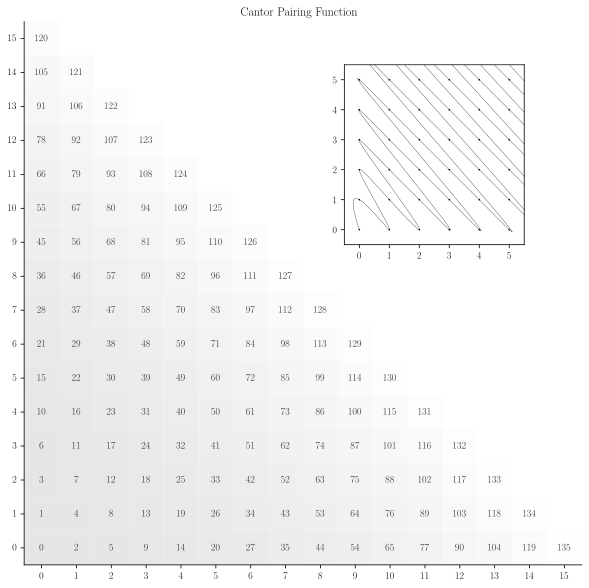

In [2]:
def cantorPair(x, y): 
    return 1/2 * (x + y) * (x + y + 1) + x

def cantorUnpair(z):
    w = np.floor((np.sqrt(8 * z + 1) - 1) / 2)
    y = z - ((w**2 + w) // 2)
    x = w - y
    return x, y

def showFunction(f, gridSize=15, insetSize=5, title=""):
    axis = np.linspace(0, gridSize, gridSize+1)
    X, Y = np.meshgrid(axis, axis)
    Z = f(X, Y)
    mask = np.ones_like(Z)
    mask[np.tril_indices_from(mask)] = False
    mask = np.flip(mask, 0)
    fig = plt.figure(figsize=(10,10))
    ax = sns.heatmap(np.round(Z).astype(np.int32), 
                     annot=True, 
                     fmt="d", 
                     mask=mask, 
                     cbar=False,
                     cmap=ListedColormap([str(x) for x in np.linspace(0.9,0.995,100)]))
    ax.invert_yaxis()
    plt.yticks(rotation=0)
    plt.title(title)
    widths = [0, 0.5]
    heights = [0.5, 0]
    gs = fig.add_gridspec(2, 2, top=0.82, bottom=0.27, left=0.27, right=0.82)
    fig.add_subplot(gs[0,1])
    xs = np.linspace(0, 40, 41)
    X, Y = np.meshgrid(xs, xs)
    Z = f(X, Y)
    order = np.argsort(Z.flatten())
    x, y = np.array([X.flatten()[order], Y.flatten()[order]])
    tck, u = splprep([x, y], s=0.01)
    unew = np.arange(0, 1, 0.00001)
    out = splev(unew, tck)
    plt.plot(*out, linewidth=0.3, c='black')
    plt.scatter(x, y, s=0.5, c='black')
    plt.xlim(left=-0.5, right=insetSize+0.5)
    plt.ylim(bottom=-0.5, top=insetSize+0.5)
    plt.xticks(np.arange(0,insetSize+1))  
    plt.yticks(np.arange(0,insetSize+1)) 
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
showFunction(cantorPair, title="Cantor Pairing Function")
plt.savefig("cantor.svg", transparent=True)

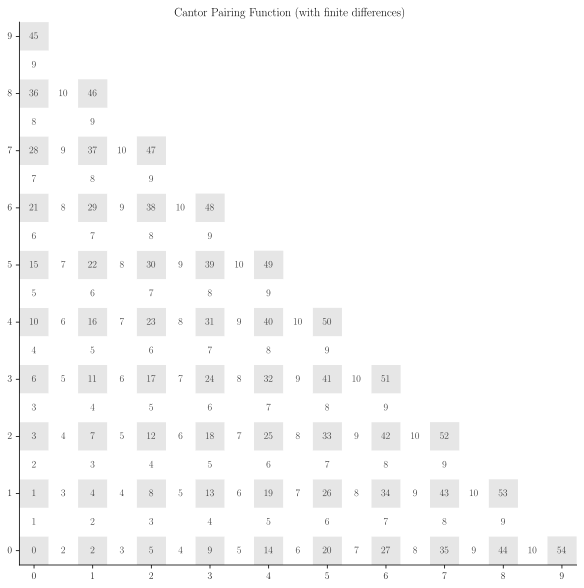

In [3]:
def withGradient(f, gridSize=10, displaySize=(10,10), title=""):
    
    # evaluate function along two-dimensional grid
    axis = np.linspace(0, gridSize-1, gridSize)
    X, Y = np.meshgrid(axis, axis)
    Z = f(X, Y)
    
    # add blank cells for padding
    blankSize = (2*Z.shape[0]-1, 2*Z.shape[0]-1)
    stepIndices = np.arange(0, gridSize*2, 2)
    Z2 = np.full(blankSize, -1)
    Z2[::2,::2] = Z
    
    # mask diagonal
    mask = np.ones_like(Z2)
    mask[np.tril_indices_from(mask)] = False
    
    # mask inner rows and columns
    mask[Z2 == -1] = True
    mask = np.flip(mask, 0)
    
    fig = plt.figure(figsize=(displaySize))
    
    # light grey
    cmap = ListedColormap([0.9, 0.9, 0.9])
    # all white
    cmaphv = ListedColormap(np.array([[1.0, 1.0, 1.0]]))
    
    # show pairing function outputs
    ax = sns.heatmap(np.round(Z2).astype(np.int32), 
                     annot=True, 
                     fmt="d", 
                     mask=mask, 
                     cbar=False,
                     cmap=cmap)
    ax.invert_yaxis()
    
    # generate difference array, add blank cells for padding
    DH = np.full(blankSize, -1)
    dH = np.diff(Z, axis=0)
    DH[1::2, ::2] = dH
    
    # build mask for horizontal difference values
    mask = np.ones_like(DH)
    mask[np.tril_indices_from(mask)] = False
    mask[DH == -1] = True
    mask = np.flip(mask, 0)
    
    # show horizontal difference values
    axh = sns.heatmap(np.round(DH).astype(np.int32), 
                 annot=True, 
                 fmt="d", 
                 mask=mask, 
                 cbar=False,
                 cmap=cmaphv)
    axh.invert_yaxis()
    
    # generate difference array, add blank cells for padding
    DV = np.full(blankSize, -1)
    dV = np.diff(Z, axis=1)
    DV[::2,1::2] = dV
    
    # build mask for vertical difference values
    mask = np.ones_like(DV)
    mask[np.tril_indices_from(mask)] = False
    mask[DV == -1] = True
    mask = np.flip(mask, 0)
    
    # show vertical difference values
    axv = sns.heatmap(np.round(DV).astype(np.int32), 
                 annot=True, 
                 fmt="d", 
                 mask=mask, 
                 cbar=False,
                 cmap=cmaphv)
    axv.invert_yaxis()
    
    # set spines only on final heatmap overlay
    axv.spines['left'].set_visible(True)
    axv.spines['bottom'].set_visible(True)

    # generate correct grid labels
    plt.yticks(stepIndices+0.5, np.arange(gridSize), rotation=0)
    plt.xticks(stepIndices+0.5, np.arange(gridSize))
    plt.title(title)
    
withGradient(cantorPair, title="Cantor Pairing Function (with finite differences)")
plt.savefig("diff.svg")

In [4]:
from sympy.abc import i, x, y
from sympy import Sum, expand

# summation
f1 = Sum(i, (i, 1, x + y + 1)).doit() - (x + 1)

# polynomial form
f2 = expand((((x + y) * (x + y + 1) / 2) + y))

# test equality
print(f1 == f2)

True


## Testing for bijectivity

We can test the first *k* natural numbers to verify that our set of pairing functions is bijective. (This doesn't prove bijectivity, but merely provides evidence.)

In [5]:
def bijectionTest(pairingFunction, unpairingFunction, k=100000):
    testArray = pairingFunction(*unpairingFunction(np.arange(k)))
    return np.all(np.round(testArray) == np.arange(k))

print(bijectionTest(cantorPair, cantorUnpair))

False


## Visualizing paths

A simple way to understand the behavior of a pairing function is to visualize the path traced by drawing a line between each successive output value $\{\,0, 1, 2 \dots\,\}$. The Cantor function results in a zigzag pattern.

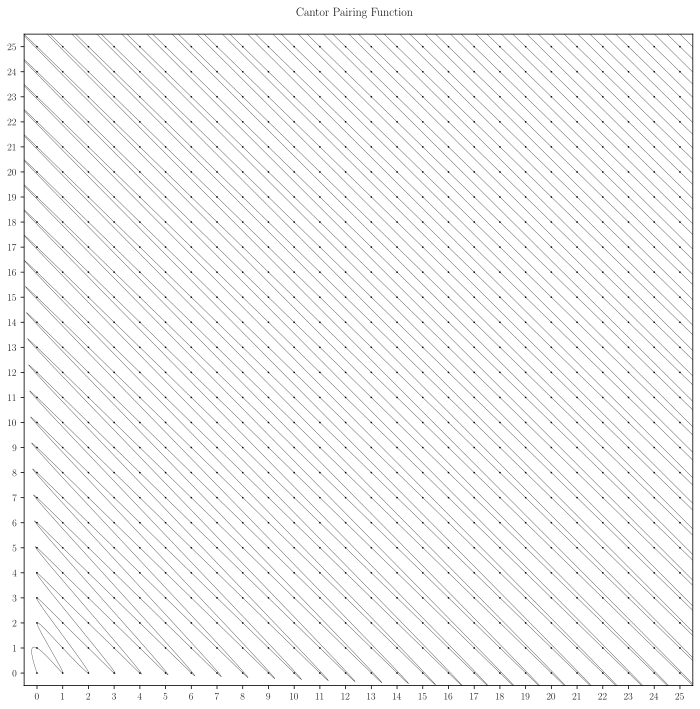

In [6]:
def splinePath(f, gridSize=26, graphSize=12, title=""):
    
    # evaluated data needs to cover at least 4x area of plot
    # (sometimes needs to be larger due to spline fitting)
    axis = np.linspace(0, gridSize*3, gridSize*3 + 1)
    X, Y = np.meshgrid(axis, axis)
    Z = f(X, Y)
    
    # determine ordering for z values
    order = np.argsort(Z.flatten())
    x, y = np.array([X.flatten()[order], Y.flatten()[order]])
    
    # generate splines to connect points
    tck, u = splprep([x, y], s=0.01)
    unew = np.arange(0, 1, 0.000001)
    out = splev(unew, tck)
    
    # plot result
    plt.figure(figsize=(graphSize, graphSize))
    plt.plot(*out, linewidth=0.3, c='black')
    plt.scatter(x, y, s=0.5, c='black')
    plt.xlim(left=-0.5, right=gridSize-0.5)
    plt.ylim(bottom=-0.5, top=gridSize-0.5)
    plt.xticks(np.arange(0,gridSize))  
    plt.yticks(np.arange(0,gridSize)) 
    plt.title(title)
    
splinePath(cantorPair, title="Cantor Pairing Function\n")
plt.show()

## Visualizing the manifold

Another way to visualize pairing functions is to view them as manifolds in 3-space. Pairing functions are defined as continuous maps from $\bf{N} \times \bf{N} \rightarrow \bf{N}$, but many pairing functions admit of a continuous extension to $\bf{R_+} \times \bf{R_+} \rightarrow \bf{R_+}$. Visualizing the continous extension the Cantor function, it can observed that it is monotone (strictly increasing) in both its arguments x and y.

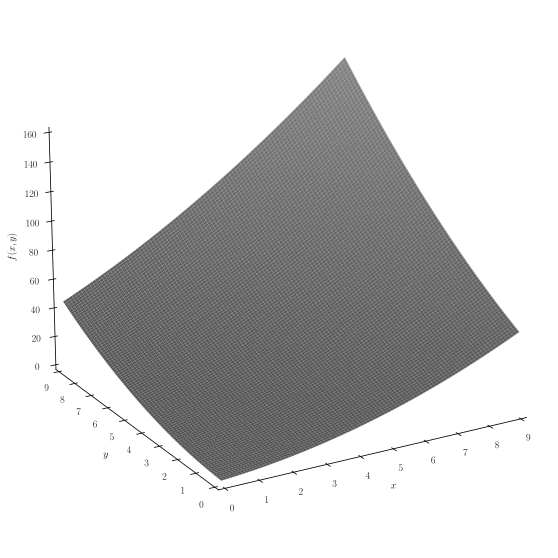

In [7]:
from mpl_toolkits import mplot3d

# Plot a three-dimensional manifold
def plotManifold(f,
                 xRange=(0,9), 
                 yRange=(0,9),
                 resolution=101,
                 title=''):
    
    # Generate a sampling of points on a grid along the manifold
    x = np.linspace(*xRange, resolution)
    y = np.linspace(*yRange, resolution)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)

    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.set_title(title)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    ax.set_zlabel('$f(x, y)$', rotation=90)
    cmap = ListedColormap([str(x) for x in np.linspace(0.3,0.5,100)])
    ax.plot_surface(X, Y, Z,
                    rstride=1,
                    cstride=1,
                    cmap=cmap, 
                    edgecolor='none',
                    rasterized=True)
    ax.view_init(20, 240)
    ax.set_xlim(0, xRange[1])
    ax.set_ylim(0, yRange[1])
    ax.set_zlim(0, np.max(Z)-20)
    plt.xticks(np.arange(xRange[1]+1))  
    plt.yticks(np.arange(yRange[1]+1)) 
    transparent = [1.0, 1.0, 1.0, 0.0]
    ax.xaxis.set_pane_color(transparent)
    ax.yaxis.set_pane_color(transparent)
    ax.zaxis.set_pane_color(transparent)
    ax.xaxis._axinfo["grid"]['color'] = transparent
    ax.yaxis._axinfo["grid"]['color'] = transparent
    ax.zaxis._axinfo["grid"]['color'] = transparent
    if title:
        plt.title(title)
    
plotManifold(cantorPair)
plt.show()

## Alternative pairing functions

The literature describes a number of pairing functions with different properties from the Cantor pairing function. One such function is the "Szudzik" pairing function, which has desirable properties for constructing certain enumerations. However, the Szudzik function does not admit of a continuous extension, nor is it monotonic. A more interesting variant of the Cantor function is known as the Boustrodephon pairing function, which traces a path much like an ox plowing a field:

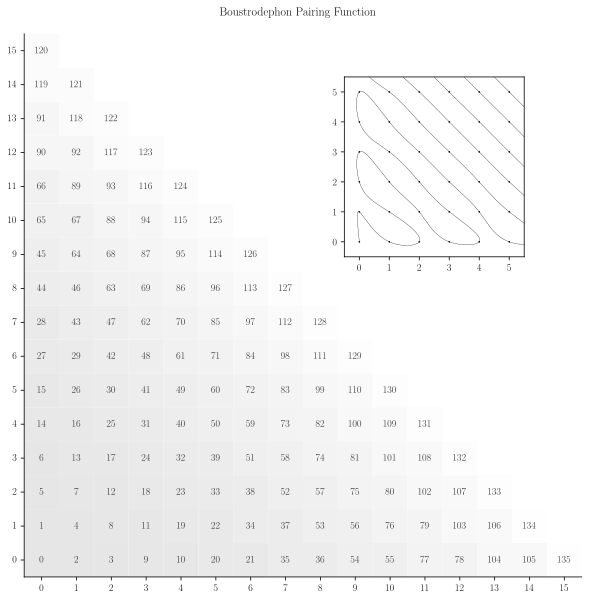

In [8]:
def boustrodephonPair(x, y):
    even_term = 1/2 * (1 + np.cos(np.pi*(x+y))) * cantorPair(y, x)
    odd_term = 1/2 * (1 + np.cos(np.pi*(x+y+1))) * cantorPair(x, y)
    return even_term + odd_term

def boustrodephonUnpair(z):
    return cantorUnpair(boustrodephonPair(*cantorUnpair(z)))

showFunction(boustrodephonPair, title="Boustrodephon Pairing Function\n")
plt.savefig("boustrodephon.svg", transparent=True)

The critical insight for constructing a continous closed form for the boustrodephon pairing function is that the parity of each sum of (x, y) coordinate pairs alternates along each diagonal. We can take advantage of this property to construct an indicator function, which is used to select whether to use to standard Cantor function or its twin with x- and y- coordinates swapped.

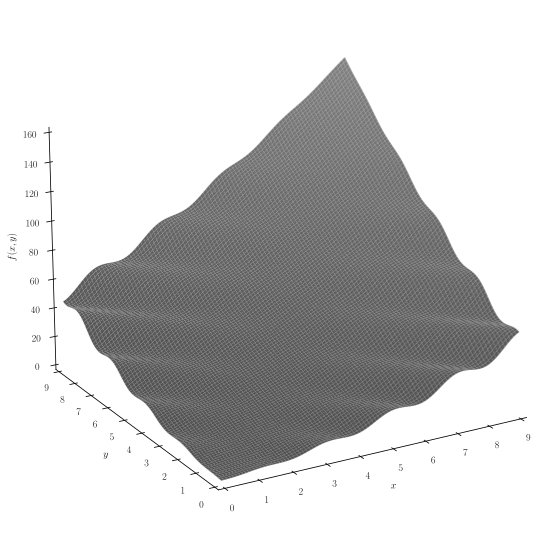

In [9]:
plotManifold(boustrodephonPair)
plt.savefig("boustrodephon_manifold.svg", transparent=True, dpi=150, bbox_inches='tight')

# Non-monotonic pairing functions

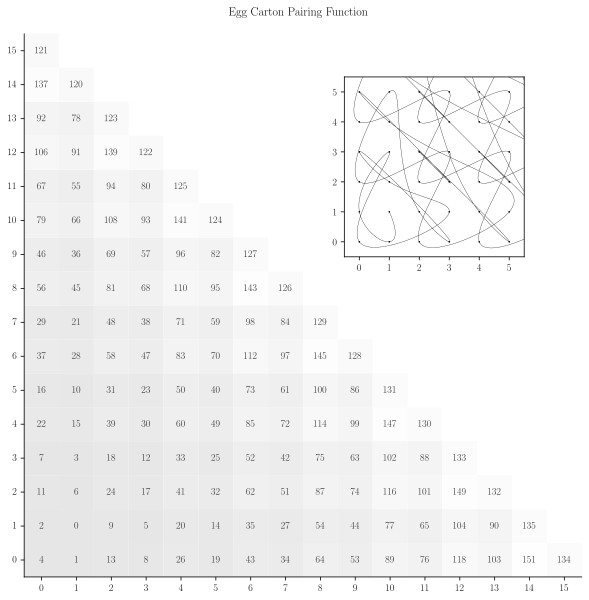

In [10]:
def eggCartonPair(x, y):
    x2 = x + np.cos(np.pi*x)
    y2 = y + np.cos(np.pi*y)
    return cantorPair(x2, y2)

def eggCartonUnpair(z):
    return cantorUnpair(eggCartonPair(*cantorUnpair(z)))

showFunction(eggCartonPair, title="Egg Carton Pairing Function\n")

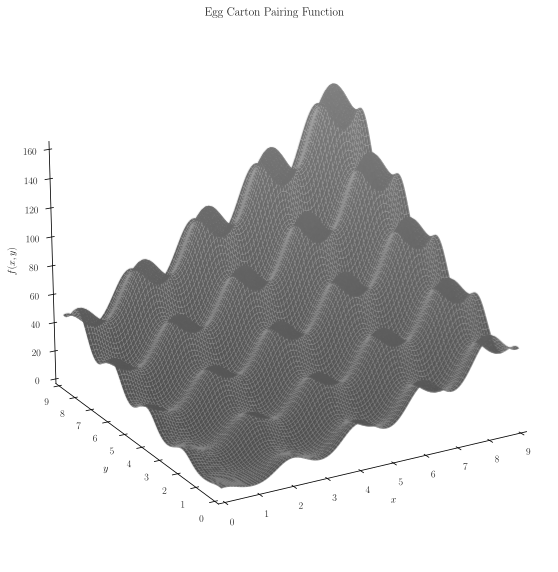

In [11]:
plotManifold(eggCartonPair, title="Egg Carton Pairing Function")

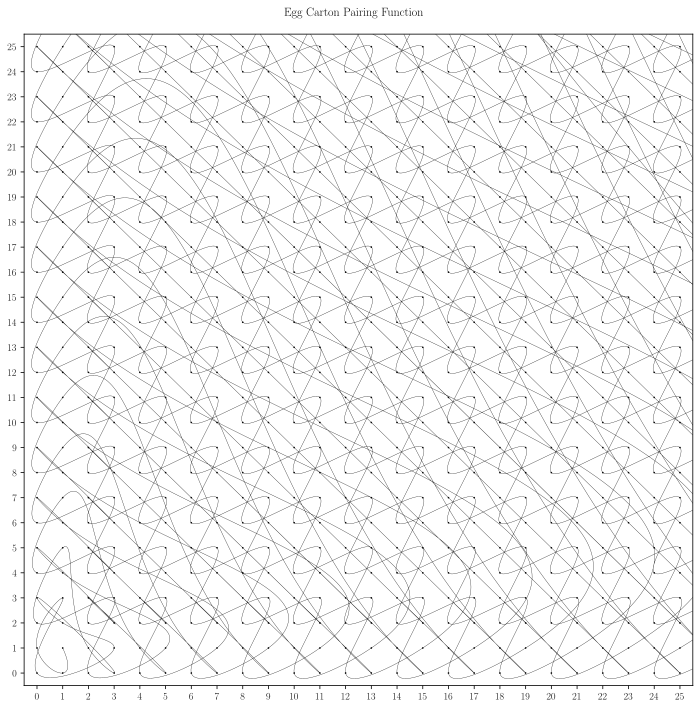

In [12]:
splinePath(eggCartonPair, title="Egg Carton Pairing Function \n")

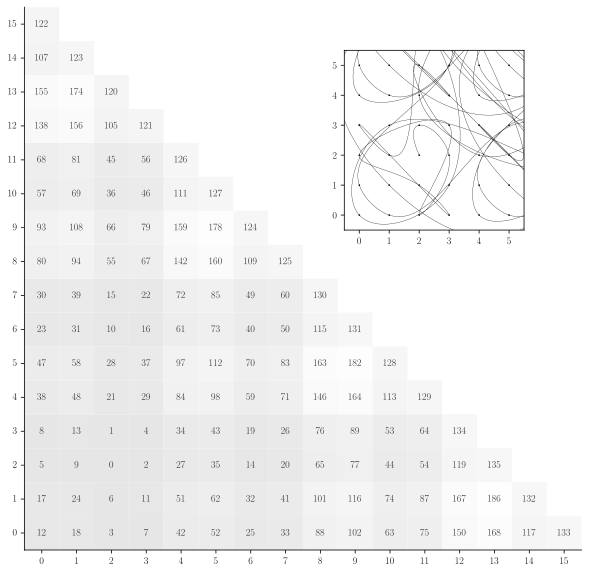

In [13]:
def doubleEggCartonPair(x, y):
    # haskell: map round $ zipWith (+) xs $ map ((*2) . (\x -> sin x + cos x) . (*(pi/2))) xs
    x2 = x + (2 * (np.sin(x*np.pi/2) + np.cos(x*np.pi/2)))
    y2 = y + (2 * (np.sin(y*np.pi/2) + np.cos(y*np.pi/2)))
    return cantorPair(x2, y2)

def doubleEggCartonUnpair(z):
    return cantorUnpair(doubleEggCartonPair(*cantorUnpair(z)))

showFunction(doubleEggCartonPair)

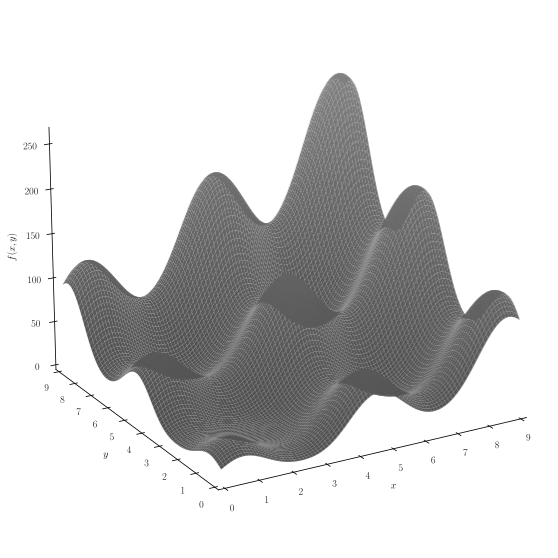

In [14]:
plotManifold(doubleEggCartonPair)

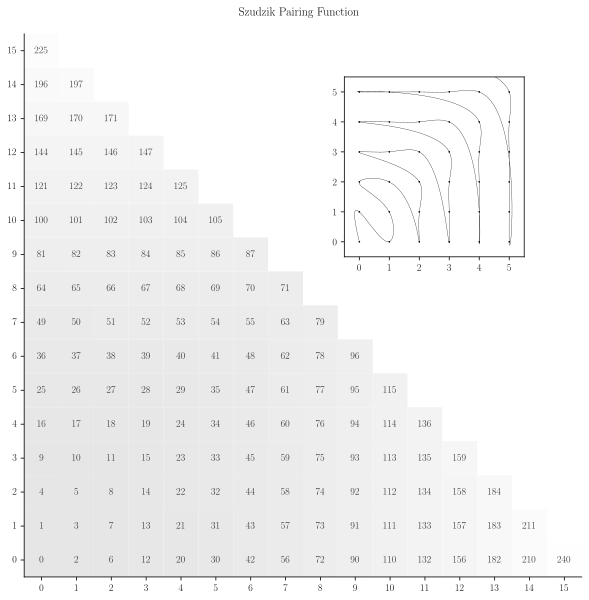

In [15]:
# From "An Elegant Pairing Function"
# (Matthew Szudzik)
# source: http://szudzik.com/ElegantPairing.pdf

def elegantPair(x, y):
    p1 = (x >= y).astype(np.int32)
    p2 = (x < y).astype(np.int32)
    return (p1 * (x**2 + x + y)) + (p2 * (y**2 + x))
    
def elegantUnpair(z):
    root = np.floor(np.sqrt(z))
    if z - root**2 < root:
        return z - root**2, root
    else:
        return root, z - root**2 - root

showFunction(elegantPair, title="Szudzik Pairing Function\n")

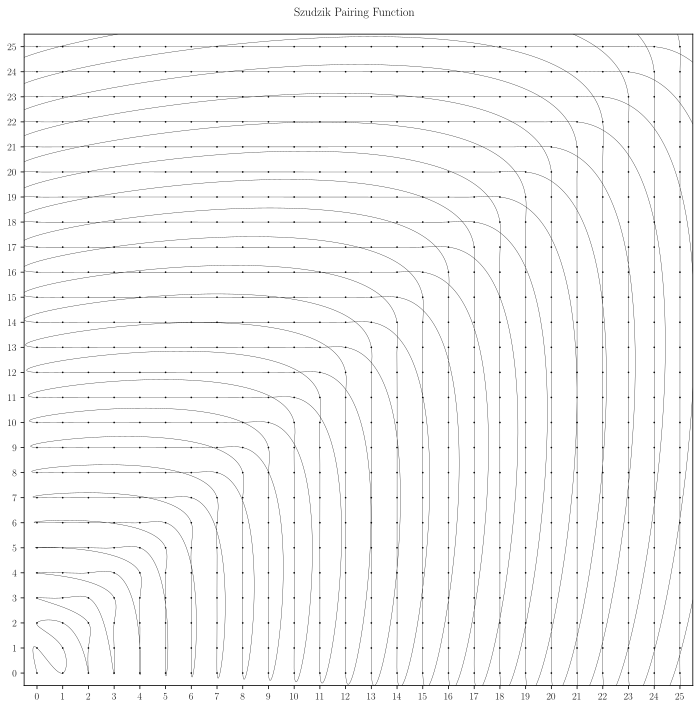

In [16]:
splinePath(elegantPair, title="Szudzik Pairing Function\n")